# Import Libraries

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Read Data

In [2]:
# Load the New York reviews data
NY_reviews = pd.read_csv('./data/New_York_reviews.csv', index_col=0)
NY_reviews.head()

C:\Users\Oxana\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\interactiveshell.py:3457: DtypeWarning: Columns (0,1,3) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,parse_count,restaurant_name,rating_review,sample,review_id,title_review,review_preview,review_full,date,city,url_restaurant,author_id
1,2,Lido,5,Positive,review_773559838,A Regular Treat,My wife and I have been eating dinner frequent...,My wife and I have been eating dinner frequent...,"October 8, 2020",New_York_City_New_York,https://www.tripadvisor.com/Restaurant_Review-...,UID_0
2,3,Lido,4,Positive,review_769429529,Good neighborhood spot!,Came with family for Labor Day weekend brunch ...,Came with family for Labor Day weekend brunch ...,"September 8, 2020",New_York_City_New_York,https://www.tripadvisor.com/Restaurant_Review-...,UID_1
3,4,Lido,1,Negative,review_745700258,Disappointing,Food was mediocre at best. The lamb chops are...,Food was mediocre at best. The lamb chops are ...,"February 17, 2020",New_York_City_New_York,https://www.tripadvisor.com/Restaurant_Review-...,UID_2
4,5,Lido,5,Positive,review_728859349,What a find in Harlem,My co-workers were volunteering at a foodbank ...,My co-workers were volunteering at a foodbank ...,"November 25, 2019",New_York_City_New_York,https://www.tripadvisor.com/Restaurant_Review-...,UID_3
5,6,Lido,5,Positive,review_728429643,Lunch,Lido is an intimate boutique style restaurant....,Lido is an intimate boutique style restaurant....,"November 23, 2019",New_York_City_New_York,https://www.tripadvisor.com/Restaurant_Review-...,UID_4


**Features**

- parse_count: numerical (integer), corresponding number of extracted review by the web scraper (auto-incremental)
- author_id: categorical (string), univocal, incremental and anonymous identifier of the user (UID_XXXXXXXXXX)
- restaurant_name: categorical (string), name of the restaurant matching the review
- rating_review: numerical (integer), review score in the range 1-5
- sample: categorical (string), indicating “positive” sample for scores [4-5] and “negative” for scores [1-3]
- review_id: categorical (string), univocal and internal identifier of the review (review_XXXXXXXXX)
- title_review: text, review title
- review_preview: text, preview of the review, truncated in the website when the text is very long
- review_full: text, complete review
- date: timestamp, publication date of the review in the format (day, month, year)
- city: categorical (string), city of the restaurant which the review was written for
- url_restaurant: text, restaurant url

In [3]:
print("The shape of review data for New York is ", NY_reviews.shape)

The shape of review data for New York is  (510463, 12)


# Data Cleaning

## 1. Remove redundant columns, e.g. review_id, city, url, parse_count

- Since the row index can serve as the unique identifier for each comment in our data set, we will remove the review_id column.
- The entire data set contains only restaurants in new york, so will drop the city column.
- The restaurant_name is sufficient for identifying the corresponding restaurant for each comment, and hence we will remove the 'url_restaurant' column.
- Lastly, the 'parse_count' column is some irrelevant information related to web scraping that we will also drop.

In [4]:
NY_reviews = NY_reviews.drop(['parse_count','review_id','city','url_restaurant'], axis = 1)
NY_reviews.shape

(510463, 8)

## 2. Remove rows with missing values

In [5]:
# Check if any missing values
NY_reviews.isna().sum()

restaurant_name    0
rating_review      0
sample             0
title_review       1
review_preview     1
review_full        2
date               2
author_id          2
dtype: int64

In [6]:
# Since the volume of missing value is extremely small and we do not know how to impute them, thus rows with missingness are dropped
NY_reviews = NY_reviews.dropna(axis = 0)
NY_reviews.shape # 2 rows are dropped

(510461, 8)

## 3. Clean data type

In [7]:
# Check the data types
NY_reviews.dtypes

restaurant_name    object
rating_review      object
sample             object
title_review       object
review_preview     object
review_full        object
date               object
author_id          object
dtype: object

In [8]:
# Find unique values in rating_review column
NY_reviews['rating_review'].unique()

array([5, 4, 1, 3, 2, '4', '5', '2', '1', '3'], dtype=object)

We will cast 'date', which is string originally, into datetime and 'rating_review', which is mix of string and integers originally, into integers.

In [9]:
# Correct the data types in 'rating_review' and 'date' column
NY_reviews['rating_review'] = NY_reviews['rating_review'].astype(int)
NY_reviews['date'] = pd.to_datetime(NY_reviews['date'])
NY_reviews.dtypes

restaurant_name            object
rating_review               int32
sample                     object
title_review               object
review_preview             object
review_full                object
date               datetime64[ns]
author_id                  object
dtype: object

## 4. Convert all text to lowercase

Later in our project, we are planning to perform analysis using text data. For keyword analysis, in order to avoid distinction between "Good" and "good", we will turn all letters into lowercase from the beginning.

In [10]:
NY_reviews['title_review'] = NY_reviews['title_review'].str.lower()
NY_reviews['review_preview'] = NY_reviews['review_preview'].str.lower()
NY_reviews['review_full'] = NY_reviews['review_full'].str.lower()

## 5. Drop duplicates

In [11]:
# Check if there are any duplicated rows
print("There are", NY_reviews.duplicated().sum(), "pairs of duplicates.")

There are 10 pairs of duplicates.


In [12]:
# Scan the 10 duplicate pairs
## Find duplicates
duplicates = NY_reviews.duplicated()
duplicated_rows = NY_reviews[duplicates]
duplicates_with = NY_reviews.duplicated(keep=False)

## Print the duplicated rows along with their duplicates
for index, row in duplicated_rows.iterrows():
    duplicates_with = NY_reviews.loc[(NY_reviews == row).all(axis=1)].index.tolist()
    print(NY_reviews.loc[duplicates_with])
    if index in duplicates_with:
        duplicates_with.remove(index)
    print(f"Row {index} is duplicated with rows: {duplicates_with}")

      restaurant_name  rating_review    sample  \
29938          Rafele              5  Positive   
29939          Rafele              5  Positive   

                              title_review  \
29938  dined like i was back in florence!!   
29939  dined like i was back in florence!!   

                                          review_preview  \
29938  my florence study abroad roommates and i get t...   
29939  my florence study abroad roommates and i get t...   

                                             review_full       date  author_id  
29938  my florence study abroad roommates and i get t... 2016-10-17  UID_25467  
29939  my florence study abroad roommates and i get t... 2016-10-17  UID_25467  
Row 29939 is duplicated with rows: [29938]
             restaurant_name  rating_review    sample  \
51155  Via_Brasil_Restaurant              5  Positive   
51156  Via_Brasil_Restaurant              5  Positive   

                              title_review  \
51155  very authentic bra

In [13]:
# Remove duplicates
NY_reviews.drop_duplicates(inplace=True)
NY_reviews.shape

(510451, 8)

## 5. Scan authors with too many reviews

We want to analyze the number of reviews each unique user wrote, and furthermore, identify the possible fake reviews.

In [14]:
# #Count the number of reviews made by one reviewer on the same day and include date to the DataFrame
# Group by author and date
grouped = NY_reviews.groupby(['author_id', 'date'])

# Count the number of reviews per author and date
review_counts = grouped.size().reset_index(name='review_count')

# Sort in descending order by review count
sorted_counts = review_counts.sort_values(by='review_count', ascending=False)

# Create a new DataFrame with author IDs, their biggest review counts in one day and the date
sorted_counts_df = pd.DataFrame({'author_id':sorted_counts['author_id'], 'date':sorted_counts['date'], 'review_count':sorted_counts['review_count'] })

display(sorted_counts[sorted_counts['review_count']>15])

,author_id,date,review_count
275205,UID_3874,2012-05-30,29
389689,UID_868,2012-01-10,24
124396,UID_17188,2016-05-20,22
35785,UID_11909,2015-11-03,18
248031,UID_29050,2012-01-20,17
246438,UID_28478,2011-12-22,16


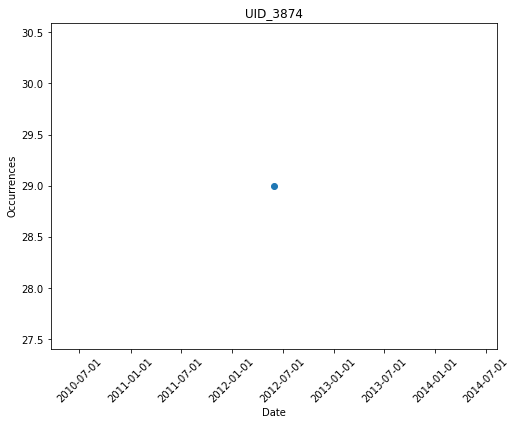

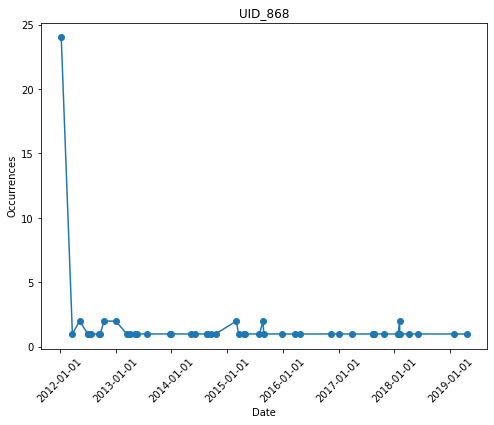

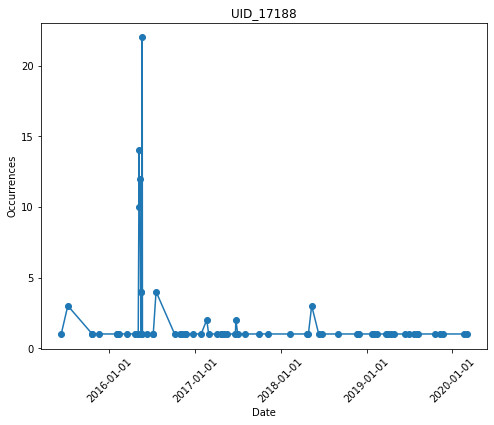

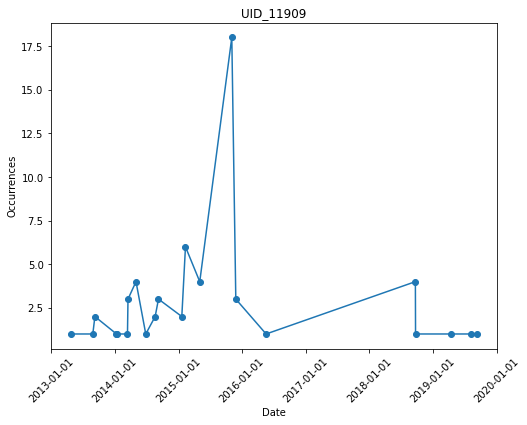

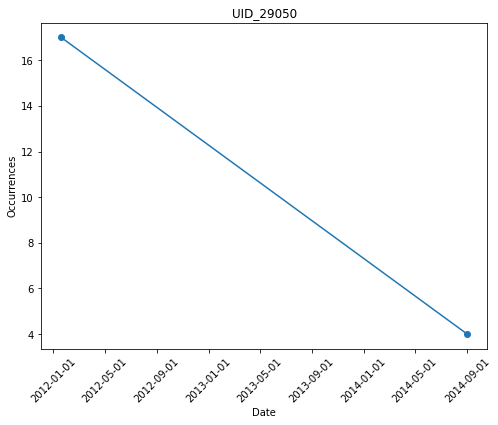

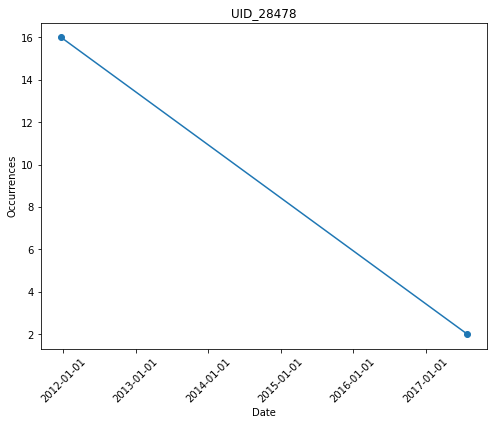

In [15]:
# #For customers who had ever made more than 15 reviews on one day, we check their review patterns over time.
fake_reviews = sorted_counts[sorted_counts['review_count']>15]
for u in fake_reviews.author_id.tolist()[:6]:
  NY_review_u = NY_reviews[NY_reviews['author_id'] == u]

  date_counts_u = NY_review_u['date'].value_counts().sort_index()
  plt.figure(figsize=(8, 6))
  plt.plot_date(date_counts_u.index, date_counts_u, '-o')
  plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
  plt.gca().xaxis.set_tick_params(rotation=45)

  plt.xlabel('Date')
  plt.ylabel('Occurrences')
  plt.title(u)

  plt.show()

In [16]:
#This reviewer left 29 reviews on different restuarants on the same day
pd.set_option('display.max_colwidth', None)

# Select the date with the highest review count
top_date = sorted_counts.iloc[0]['date']

# Filter the original reviews data frame for the selected author and date
selected_reviews_3874 = NY_reviews[(NY_reviews['author_id'] == 'UID_3874') & (NY_reviews['date'] == top_date)]
selected_reviews_3874

,restaurant_name,rating_review,sample,title_review,review_preview,review_full,date,author_id
4107,Cafe_Mogador,4,Positive,great deal,"a moroccan place in the heart of east village. often confused with cafe orlin: the size and space and food is very similar… it’s great for people on a budget…got the yogurt tangine [served with pita]- so good we got two orders of it,...","a moroccan place in the heart of east village. often confused with cafe orlin: the size and space and food is very similar… it’s great for people on a budget… got the yogurt tangine [served with pita]- so good we got two orders of it, merguez sandwich, the chicken tangine [w/charmoulla] and halumi eggs [poached eggs with roasted tomato, halumi cheese, salad.] i would definitely order the yogurt and the sandwich again. they’re standard and delicious. the tangine was merely acceptable. not great at all. they’re best known for their halumi eggs, but it was wayyy overcooked this time around. they need to be consistent with their food quality. i’m never sure if it’ll be good or not. overall, i think the food experience at cafe orlin is better, though the service at both is really slow and you shouldn’t be in a hurry if you decide to eat here.",2012-05-30,UID_3874
14667,Hakata_Ippudo_NY,4,Positive,"good, but overrated.","the king of pork buns. but that is all. it isn’t worth getting a ramen with sodium overload. some people may love it, but i’ve had better. the ramen [i’ve sampled them all over the years, and my conclusion is that the ramen is too...","the king of pork buns. but that is all. it isn’t worth getting a ramen with sodium overload. some people may love it, but i’ve had better. the ramen [i’ve sampled them all over the years, and my conclusion is that the ramen is too greasy for me] the pork buns are the perfect blend of smooth, spicy, and flavorful for every bite. the best of the best. yum. too bad they don’t allow you to get them to go!",2012-05-30,UID_3874
21884,Little_Owl,3,Negative,don't expect too much,"although the little owl might get rave reviews, i find the food very average. the best thing about it is that the service is down to earth and there is the cutest red door.outside of that, the restaurant is small, the food is mediocre,...","although the little owl might get rave reviews, i find the food very average. the best thing about it is that the service is down to earth and there is the cutest red door. outside of that, the restaurant is small, the food is mediocre, and i have been multiple times and have never experienced why/how people think they have the best burgers in town. not somewhere i'd go out of the way for, but decent.",2012-05-30,UID_3874
41244,Russ_Daughters,5,Positive,best smoked salmon,"as much as i love sandwiches, i prefer eating my bagels open-faced: with all the cream cheese, smoked salmon, tomatoes, onions, chives, etc. then continuing onto the other side. i do not like eating them sandwich-style.i had a pumpernickle bagel, tofu scallion cream cheese,...","as much as i love sandwiches, i prefer eating my bagels open-faced: with all the cream cheese, smoked salmon, tomatoes, onions, chives, etc. then continuing onto the other side. i do not like eating them sandwich-style. i had a pumpernickle bagel, tofu scallion cream cheese, & scottish salmon loin. the scottish salmon loin cut is the filet mignon of the fish. i love it so much that i usually order a little extra so i can eat it on the side [in addition to what is already in my bagel]~yes, that good. the smoked fish here is great; do not opt for the seafood salad weak stuff. you gotta go real deal. the pumpernickle is great here, & the bagel is the right balance between chewy and soft. my only qualm is that i’m eating two thick pieces of the bagel in every bite. i can imagine it being even better if i was eating it open faced! and with a friend!! sitting down!!! anyway, this meal costs about $15 for 1 bagel sandwich [without the extra order of fish]. its a pretty price to 

In [17]:
#This reviewer left 24 reviews on different restuarants on the same day

# Select the date with the highest review count
top_date = sorted_counts.iloc[1]['date']

# Filter the original reviews data frame for the selected author and date
selected_reviews_868 = NY_reviews[(NY_reviews['author_id'] == 'UID_868') & (NY_reviews['date'] == top_date)]
selected_reviews_868

,restaurant_name,rating_review,sample,title_review,review_preview,review_full,date,author_id
5728,Marea,4,Positive,precious,"very good and elegant, event dinner and extremely thought about menu but really just a little ""precious"". very euro. very importante","very good and elegant, event dinner and extremely thought about menu but really just a little ""precious"". very euro. very importante",2012-01-10,UID_868
22496,Del_Posto,3,Negative,disappointed,"thought this would be the absolute best after hearing rave reviews but it just wasn't special. everything was ok, formal, considerate service but not that memorable. maybe i was in a bad mood. bring all your credit cards.","thought this would be the absolute best after hearing rave reviews but it just wasn't special. everything was ok, formal, considerate service but not that memorable. maybe i was in a bad mood. bring all your credit cards.",2012-01-10,UID_868
33786,John_s_of_Bleecker_Street,5,Positive,new york classic,"is it still there? are the wooden booths still filled with scribbles. is the pizza still fresh, thin and perfecto? veddy good.","is it still there? are the wooden booths still filled with scribbles. is the pizza still fresh, thin and perfecto? veddy good.",2012-01-10,UID_868
82785,BLT_Steak,5,Positive,mmmmmmm,"yum. big juicy steaks, onion rings yum lotsa guys. comfortable , great staff, definitely a treat. i deserve it, don't you?","yum. big juicy steaks, onion rings yum lotsa guys. comfortable , great staff, definitely a treat. i deserve it, don't you?",2012-01-10,UID_868
85116,Jean_Georges,4,Positive,ah yes,"jean georges is what it sets out to be - quietly elegant, gourmet food, great location, interesting clientelle. you might be seated next to a baron, or a donald or a hedge fund guy or a great pianist, who knows?","jean georges is what it sets out to be - quietly elegant, gourmet food, great location, interesting clientelle. you might be seated next to a baron, or a donald or a hedge fund guy or a great pianist, who knows?",2012-01-10,UID_868
103930,Balthazar,5,Positive,"balthazar , c'est si bon","friendly staff although cramped when you enter. always fun, always good. a parisian paradise in soho.","friendly staff although cramped when you enter. always fun, always good. a parisian paradise in soho.",2012-01-10,UID_868
111495,Eataly,4,Positive,square market,"fun in a market sort of way. a little hectic to the restaurants. overall a casual, enjoyable new york experience, a delightful addition to the square.","fun in a market sort of way. a little hectic to the restaurants. overall a casual, enjoyable new york experience, a delightful addition to the square.",2012-01-10,UID_868
120109,Cafe_Boulud,4,Positive,consistent,quiet neighborhood bistro. excellent chef. well done. it will not hit you over the head but you will return for the feeling of a relaxed dinner at home ( with a wonderful chef of course),quiet neighborhood bistro. excellent chef. well done. it will not hit you over the head but you will return for the feeling of a relaxed dinner at home ( with a wonderful chef of course),2012-01-10,UID_868
123653,Gotham_Bar_Grill,5,Positive,a refined experience,low key excellence from decor to menu selection. you will be well taken care of and feel superb at the end. been back many times and always a winner.,low key excellence from decor to menu selection. you will be well taken care of and feel superb at the end. been back many times and always a winner.,2012-01-10,UID_868
144732,Eleven_Madison_Park,5,Positive,top choice,"expensive- yes, crowded seating-maybe, great dining experience, highly recommended for a wow and you will want to return.","expensive- yes, crowded seating-maybe, great dining experience, highly recommended for a wow and you will want to return.",2012-01-10,UID_868


In [18]:
#This reviewer left 22 reviews on different restuarants on the same day
# Select the date with the highest review count
top_date = sorted_counts.iloc[2]['date']

# Filter the original reviews data frame for the selected author and date
selected_reviews_17188 = NY_reviews[(NY_reviews['author_id'] == 'UID_17188') & (NY_reviews['date'] == top_date)]
selected_reviews_17188

,restaurant_name,rating_review,sample,title_review,review_preview,review_full,date,author_id
26497,Margon,5,Positive,great food,easy laid back vibe. casual dining. take out or eat in.great tasting food with yummy shakes.near time sq.,easy laid back vibe. casual dining. take out or eat in.great tasting food with yummy shakes.near time sq.,2016-05-20,UID_17188
81833,Birdland,4,Positive,great performances,django reinhardt festival annually is a great event.great performances here small venue food and drinks available.,django reinhardt festival annually is a great event.great performances here small venue food and drinks available.,2016-05-20,UID_17188
96139,Arturo_s,4,Positive,good pizza,been here for ages good village spot.good brick oven pizza.gets busy on the weekend. don't think they take reservations,been here for ages good village spot.good brick oven pizza.gets busy on the weekend. don't think they take reservations,2016-05-20,UID_17188
111402,Artichoke_Basille_s_Pizza,5,Positive,creamy pizza,"great pizza, yummy cheesy, 1 slice is enough. this is not thin crust.heavy duty thick pizza. lines can be long.","great pizza, yummy cheesy, 1 slice is enough. this is not thin crust.heavy duty thick pizza. lines can be long.",2016-05-20,UID_17188
137342,Pret_A_Manger,4,Positive,decent,"i will say, how do they keep their bread crispy. the mini sandwiches are always fresh with a crispy baguette never spongy.","i will say, how do they keep their bread crispy. the mini sandwiches are always fresh with a crispy baguette never spongy.",2016-05-20,UID_17188
142892,Ear_Inn,3,Negative,old school pub,dive bar with locals.small place with history.great for drinks with friends. not much else. out of the area a bit,dive bar with locals.small place with history.great for drinks with friends. not much else. out of the area a bit,2016-05-20,UID_17188
159019,Riverpark,3,Negative,not bad,came here for restaurant week was a decent pre fix meal on the east river but very noisy with the fdr right outside.,came here for restaurant week was a decent pre fix meal on the east river but very noisy with the fdr right outside.,2016-05-20,UID_17188
177129,Strip_House,4,Positive,great steak,great steak house with a lounge feel. dark and mysterious inside with comfy red velvet couches. porterhouse is great also filet mignon.,great steak house with a lounge feel. dark and mysterious inside with comfy red velvet couches. porterhouse is great also filet mignon.,2016-05-20,UID_17188
229125,Untitled_at_the_Whitney,4,Positive,great service,"stopped here for drinks, our waiter was the best.suggested a really good drink had some conversation. friendly staff good crowd.","stopped here for drinks, our waiter was the best.suggested a really good drink had some conversation. friendly staff good crowd.",2016-05-20,UID_17188
247744,Bread_Butter,3,Negative,many choices,good salad bar with many choices. quick abrupt service.sorta want you in and out. next next next is all you here but good for a fresh squeezed ginger shot when you under the weaher.,good salad bar with many choices. quick abrupt service.sorta want you in and out. next next next is all you here but good for a fresh squeezed ginger shot when you under the weaher.,2016-05-20,UID_17188


In [19]:
#This reviewer left 18 reviews on different restuarants on the same day

# Select the date with the highest review count
top_date = sorted_counts.iloc[3]['date']

# Filter the original reviews data frame for the selected author and date
selected_reviews_11909 = NY_reviews[(NY_reviews['author_id'] == 'UID_11909') & (NY_reviews['date'] == top_date)]
selected_reviews_11909

,restaurant_name,rating_review,sample,title_review,review_preview,review_full,date,author_id
13108,Marea,5,Positive,the best,"this was our second visit to marea, and everything changed for good. despite the boring and intrusive company, and the bad weather, everybody got their alerts in their smartphone about the terrible rain outside. it was the best. the red wine, ""tyler"" made me happy....","this was our second visit to marea, and everything changed for good. despite the boring and intrusive company, and the bad weather, everybody got their alerts in their smartphone about the terrible rain outside. it was the best. the red wine, ""tyler"" made me happy. it is a power scene lunch. high end and really fine. the service has the best vibe. we loved the five course chef tasting. the best italian restaurant in new york with a michelin star.",2015-11-03,UID_11909
41536,The_Polo_Bar,5,Positive,sterling,"to get in the polo bar you have to tell your reservation name outside in the street to the staff, all dressed in ralph lauren. you walk into the bar, wait, then you take an elevator and go to the main salon, decorated by ralph...","to get in the polo bar you have to tell your reservation name outside in the street to the staff, all dressed in ralph lauren. you walk into the bar, wait, then you take an elevator and go to the main salon, decorated by ralph lauren. the space is lavish. the waiters are very friendly, their treat is gracious. the menu is small but with good recommendations. their steak is from the ranch of mr. lauren. one of the best steaks i've eaten. deluxe. we loved the polo bar. a high level restaurant. palatial, one of the best night outs. the chocolate soufflé was sterling.",2015-11-03,UID_11909
75394,Il_Gattopardo,3,Negative,refined italian,"italian nouvelle cuisine in a cold, hidden and desolate location. you can be in front and not find it, you have to walk down a rounded stairs. the food is satisfying and the quality valuable. refined and a bit depressing.","italian nouvelle cuisine in a cold, hidden and desolate location. you can be in front and not find it, you have to walk down a rounded stairs. the food is satisfying and the quality valuable. refined and a bit depressing.",2015-11-03,UID_11909
79215,5_Napkin_Burger_Hell_s_Kitchen,4,Positive,my burger was delicious.,"my burger was delicious. always crowded and the tables very close. post theater, they have sushi and red wine. the staff is cool. new yorkers love this place. delicious and yummy experience. it has various locations and they are growing. it is the modern concept...","my burger was delicious. always crowded and the tables very close. post theater, they have sushi and red wine. the staff is cool. new yorkers love this place. delicious and yummy experience. it has various locations and they are growing. it is the modern concept of a cafeteria. if i'm starving and walking in new york and find a 5nb i don't think it and walk inside.",2015-11-03,UID_11909
127043,Le_Parisien,4,Positive,great bistro,"it is a small place, with the bonsoir monsieur attitude s'il vous plaît. you feel in the french riviera. informal. went for dinner, reserved through open table. the best steak tartare, the best escargots, the red wine warm like a bistro. good looking serveuse. the...","it is a small place, with the bonsoir monsieur attitude s'il vous plaît. you feel in the french riviera. informal. went for dinner, reserved through open table. the best steak tartare, the best escargots, the red wine warm like a bistro. good looking serveuse. the best french bistro recently.",2015-11-03,UID_11909
141473,ABC_Kitchen,1,Negative,a total failure.,"oh deception, waiting so much for this? the service was rushed, th food was bad, you can eat better anywhere. a disaster. we were excited to try the popular and famous abc kitchen. we've been to abc cocina and it was way better. the plates...","oh deception, waiting so much for this? the service was rushed, th food was bad, you can e

In [20]:
#This reviewer left 17 reviews on different restuarants on the same day
# Select the date with the highest review count
top_date = sorted_counts.iloc[4]['date']

# Filter the original reviews data frame for the selected author and date
selected_reviews_29050 = NY_reviews[(NY_reviews['author_id'] == 'UID_29050') & (NY_reviews['date'] == top_date)]
selected_reviews_29050

,restaurant_name,rating_review,sample,title_review,review_preview,review_full,date,author_id
34456,Tony_s_Di_Napoli_Midtown,5,Positive,the best of the best,i love this place with all of my heart. they will always fit you in...the eggplant parm is the best i have ever had... the waitstaff are so good at what they do... we wanted for nothing during our meal. i eat here about...,i love this place with all of my heart. they will always fit you in... the eggplant parm is the best i have ever had... the waitstaff are so good at what they do... we wanted for nothing during our meal. i eat here about six times a year and whenever i see a broadway show... convenient.. they get you in and out quickly if need be... not to be missed!,2012-01-20,UID_29050
48880,Carmine_s_Italian_Restaurant_Times_Square,4,Positive,good fun,not as good as tony dinapoli's and if you want to pay more go to carmine's. but i suspect you will seek out tony's over carmine's.,not as good as tony dinapoli's and if you want to pay more go to carmine's. but i suspect you will seek out tony's over carmine's.,2012-01-20,UID_29050
79816,The_Perfect_Pint,4,Positive,after work destination,"fun atmosphere, good staff, plentiful bar... great margarita!","fun atmosphere, good staff, plentiful bar... great margarita!",2012-01-20,UID_29050
102710,Aquavit,5,Positive,excellent,another diamond in the rough.... you will enjoy the food... go go and go soon.,another diamond in the rough.... you will enjoy the food... go go and go soon.,2012-01-20,UID_29050
111644,Eataly,5,Positive,go to eataly,what a neat place this is... it is a marketplace for everything italian.. especially the olive bread... i could not stop eating it...i didn't actually eat at any of the restaurants yet... but i hear nothing but good things... it's a great way to...,what a neat place this is... it is a marketplace for everything italian.. especially the olive bread... i could not stop eating it... i didn't actually eat at any of the restaurants yet... but i hear nothing but good things... it's a great way to enjoy a couple hours shopping for fresh and hard to find ingredients...,2012-01-20,UID_29050
138376,Nobu,2,Negative,skip it,too expensive for what you get... they must have great marketing people because you would think this place was the bomb.. but it definitely is not.,too expensive for what you get... they must have great marketing people because you would think this place was the bomb.. but it definitely is not.,2012-01-20,UID_29050
152376,21_Club,5,Positive,super,was taken here for lunch a couple of weeks ago. had the salmon... omg! and the dessert was truly spectacular... this place has an interesting history and i love love love the original frederic remington artwork all around the place... i also like the renovation...,was taken here for lunch a couple of weeks ago. had the salmon... omg! and the dessert was truly spectacular... this place has an interesting history and i love love love the original frederic remington artwork all around the place... i also like the renovation they made to the front of the house... they added an additional bar and sitting area... well done...,2012-01-20,UID_29050
161709,Churrascaria_Plataforma,4,Positive,vegetarians love this place too,i do not eat meat but when with some colleagues... there were so many options for me to eat... i could barely walk when i left the place... really neat concept...,i do not eat meat but when with some colleagues... there were so many options for me to eat... i could barely walk when i left the place... really neat concept...,2012-01-20,UID_29050
179751,Loeb_Boathouse_Central_Park,5,Positive,beautiful location,waiters were excellent. food was tasty...and plentiful. include this restaurant in your trip into central park... it's closer to the east side....,waiters were excellent. food was tasty...and plentiful. include this restaurant in your trip into central park... it's closer to the east side....,2012-01-20,UID_29050
187536,Nobu,2,Nega

In [21]:
#This reviewer left 17 reviews on different restuarants on the same day
# Select the date with the highest review count
top_date = sorted_counts.iloc[5]['date']

# Filter the original reviews data frame for the selected author and date
selected_reviews_28478 = NY_reviews[(NY_reviews['author_id'] == 'UID_28478') & (NY_reviews['date'] == top_date)]
selected_reviews_28478

,restaurant_name,rating_review,sample,title_review,review_preview,review_full,date,author_id
33749,John_s_of_Bleecker_Street,4,Positive,ol timer,"it is true what they say about john's. it is the best pizza in new york,","it is true what they say about john's. it is the best pizza in new york,",2011-12-22,UID_28478
50255,5_Napkin_Burger_Hell_s_Kitchen,3,Negative,local hangout,"the regulars outnumber the first timers. this is practically a club, a well fed club.","the regulars outnumber the first timers. this is practically a club, a well fed club.",2011-12-22,UID_28478
96316,Bubby_s,3,Negative,local favorite,this place is a tribecca standby. ordinary food in plain setting. but you'll grow to like it if you live nearby.,this place is a tribecca standby. ordinary food in plain setting. but you'll grow to like it if you live nearby.,2011-12-22,UID_28478
103767,Balthazar,4,Positive,always crowded,"i'd like this place better if the crowds were missing. it is a good place for oysters, for coffee, for looking around soho.","i'd like this place better if the crowds were missing. it is a good place for oysters, for coffee, for looking around soho.",2011-12-22,UID_28478
107078,Union_Square_Cafe,3,Negative,let's have lunch,this place is always a treat. sometimes better than others. you won't be sorry.,this place is always a treat. sometimes better than others. you won't be sorry.,2011-12-22,UID_28478
111258,Eataly,2,Negative,too many people,"chaos. if that is what you want with an italian accent, then welcome.","chaos. if that is what you want with an italian accent, then welcome.",2011-12-22,UID_28478
174405,Katz_s_Deli,2,Negative,want to eat on a crowded subway?,"hustle and bustle and slam bang, too. but the corned beef sandwich is almost worth it.","hustle and bustle and slam bang, too. but the corned beef sandwich is almost worth it.",2011-12-22,UID_28478
178782,Loeb_Boathouse_Central_Park,2,Negative,everything depends on the service,"lovely venue. ok food. but you go for the occasion, and service is important.","lovely venue. ok food. but you go for the occasion, and service is important.",2011-12-22,UID_28478
195140,Molyvos,3,Negative,good looking greek,"old reliabel greek. nothing special, though. don't order the mousakka.","old reliabel greek. nothing special, though. don't order the mousakka.",2011-12-22,UID_28478
275219,Blue_Smoke_Flatiron,2,Negative,like barbeque?,"it is pleasant enough if you love this style of cooking. if not, grin and stay with the good drinks.","it is pleasant enough if you love this style of cooking. if not, grin and stay with the good drinks.",2011-12-22,UID_28478


<!--  Comment on the users with > 15 reviews on one day -->
- We observe that for 3 of our 6 flagged users the rating counts are > 15 in Jan of 2012.
- For author `UID_3874`, who made 29 reviews on one day, the reviews seem legit, thus the reviews from this author are kept.
- For author `UID_868`, who made 24 reviews on one day, the 24 reviews this author left on 2012-1-10 are shorter in length compared to the ones the author wrote later. However, the content looks legit. It could be that 2012-1-10 was the first day the author created an account. Thus, the reviews from this author are kept.
- For author `UID_17188`, who made 22 reviews on one day, the reviews are pretty short but describing, look legit, thus the reviews from this author are kept.
- For author `UID_11909`, who made 18 reviews on one day, the reviews seem genuine and there is no anomaly observed and hence are retained.
- For author `UID_29050`, who made 17 reviews on one day, the reviews seem legit, thus the reviews from this author are kept.
- For author `UID_28478`, who made 16 reviews on one day, the reviews seem legit, thus the reviews from this author are kept.


Thus we decide to move forward (xxx).

## 6. Save the cleaned data set as a separate file

In [22]:
NY_reviews.to_csv('./data/New_York_reviews_cleaned.csv',  sep=',')